In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve, auc, balanced_accuracy_score, matthews_corrcoef
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories for saving models and assets
os.makedirs('models', exist_ok=True)
os.makedirs('assets', exist_ok=True)


PyTorch version: 2.8.0+cu128
CUDA available: True
Using device: cuda


In [2]:
# Load cleaned dataset
df = pd.read_csv('./data/cleaned_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"Sepsis cases: {df['SepsisLabel'].sum()} ({df['SepsisLabel'].mean():.1%})")
print(f"Patients: {df['Patient_ID'].nunique()}")
df.head()


Dataset shape: (1552210, 44)
Sepsis cases: 27916 (1.8%)
Patients: 40336


,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,65.0,100.0,35.78,129.0,72.0,69.0,16.5,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,1,0,17072
1,1,1,65.0,100.0,35.78,129.0,72.0,69.0,16.5,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,2,0,17072
2,2,2,78.0,100.0,35.78,129.0,42.5,69.0,16.5,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,3,0,17072
3,3,3,73.0,100.0,35.78,129.0,42.5,69.0,17.0,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,4,0,17072
4,4,4,70.0,100.0,35.78,129.0,74.0,69.0,14.0,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,5,0,17072


In [3]:
# Define feature columns (exclude ID, target, time columns, and Unit1/Unit2 which are redundant)
exclude_cols = ['Patient_ID', 'SepsisLabel', 'Hour', 'Unnamed: 0', 'ICULOS', 'Unit1', 'Unit2']
feature_cols = [col for col in df.columns if col not in exclude_cols]
print(f"Feature columns ({len(feature_cols)}): {feature_cols[:10]}...")
print(f"Full feature list: {feature_cols}")


Feature columns (37): ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3']...
Full feature list: ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'HospAdmTime']


In [10]:
# percentage of sepsis cases
x = df['SepsisLabel'].value_counts()
x[0]/(x[0]+x[1])


0.9820153200919979

In [4]:
# Prepare tabular data
X_tabular = df[feature_cols].fillna(0)  # Handle any remaining NaN values
y_tabular = df['SepsisLabel']

# Split data FIRST (before any preprocessing)
X_train_tab, X_test_tab, y_train_tab, y_test_tab = train_test_split(
    X_tabular, y_tabular, test_size=0.2, random_state=42, stratify=y_tabular
)

# Normalize features AFTER splitting (fit on training data only)
scaler_tabular = StandardScaler()
X_train_tab = scaler_tabular.fit_transform(X_train_tab)  # Fit and transform training data
X_test_tab = scaler_tabular.transform(X_test_tab)        # Only transform test data (no fitting)

print(f"Training set: {X_train_tab.shape[0]} samples")
print(f"Test set: {X_test_tab.shape[0]} samples")


Training set: 1241768 samples
Test set: 310442 samples



Shape of tree scores: (310442, 37)
(rows = samples, columns = individual tree scores)

Sample predictions from each tree (first 3 samples):
[[0.5691896  0.40442374 0.38881654 0.6575326  0.48191866 0.44211572
  0.48971623 0.69449395 0.5679468  0.39776456 0.58658725 0.6747396
  0.5264313  0.5253658  0.5634221  0.18959892 0.7651159  0.45624676
  0.577619   0.5665549  0.5803792  0.37980717 0.5687544  0.4701364
  0.8211823  0.3413162  0.59331703 0.6867857  0.5868006  0.5581935
  0.59144986 0.49205923 0.6174513  0.28637454 0.703296   0.62126946
  0.36105993]
 [0.4489671  0.5405422  0.39207083 0.6475046  0.553038   0.59762615
  0.60190856 0.4972802  0.46465674 0.38550717 0.51352227 0.43384665
  0.68726015 0.646013   0.5346974  0.6444645  0.48562306 0.57156086
  0.57572234 0.43738338 0.48678342 0.6035921  0.6060988  0.45683962
  0.59043616 0.21541318 0.6225914  0.5539228  0.48550165 0.64712226
  0.6191596  0.5504451  0.38620612 0.4338755  0.21762648 0.48999232
  0.64302677]
 [0.52296704 0.635

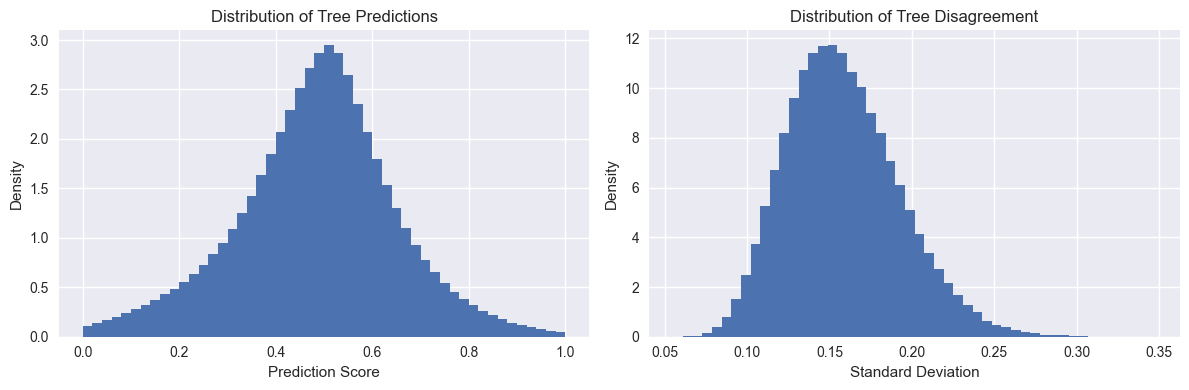

In [11]:
# Train and evaluate complex tree voting model
from tree_voting_model import TreeVotingModel

# Create and train model with more trees
model = TreeVotingModel(n_trees=5000)
model.fit(X_train_tab, y_train_tab)

# Get individual tree predictions
tree_scores = model.get_tree_predictions(X_test_tab)
print("\nShape of tree scores:", tree_scores.shape)
print("(rows = samples, columns = individual tree scores)")

# Show sample predictions from each tree
print("\nSample predictions from each tree (first 3 samples):")
print(tree_scores[:3])

# Show prediction distribution
print("\nPrediction Distribution:")
print(f"Mean: {tree_scores.mean():.3f}")
print(f"Std: {tree_scores.std():.3f}")
print(f"Min: {tree_scores.min():.3f}")
print(f"Max: {tree_scores.max():.3f}")
print(f"% Strong positive (>0.8): {(tree_scores > 0.8).mean() * 100:.1f}%")
print(f"% Strong negative (<0.2): {(tree_scores < 0.2).mean() * 100:.1f}%")

# Make final predictions
y_pred = model.predict(X_test_tab, threshold=0.4)  # Adjusted threshold

# Print metrics
print("\nModel Performance:")
print(f"Precision: {precision_score(y_test_tab, y_pred):.3f}")
print(f"Recall: {recall_score(y_test_tab, y_pred):.3f}")
print(f"F1: {f1_score(y_test_tab, y_pred):.3f}")

# Show tree disagreement
disagreement = np.std(tree_scores, axis=1)
print(f"\nTree Disagreement:")
print(f"Mean: {disagreement.mean():.3f}")
print(f"Max: {disagreement.max():.3f}")
print(f"% High disagreement (std>0.2): {(disagreement > 0.2).mean() * 100:.1f}%")

# Plot prediction distribution
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(tree_scores.flatten(), bins=50, density=True)
plt.title('Distribution of Tree Predictions')
plt.xlabel('Prediction Score')
plt.ylabel('Density')

plt.subplot(122)
plt.hist(disagreement, bins=50, density=True)
plt.title('Distribution of Tree Disagreement')
plt.xlabel('Standard Deviation')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [ ]:
# Train and evaluate simple voting model
from simple_voting_model import SimpleVotingModel

# Create and train model
model = SimpleVotingModel(n_estimators=5, max_depth_range=(3, 15))
model.fit(X_train_tab, y_train_tab)

# Get individual voter predictions
voter_probas = model.predict_proba(X_test_tab)
print("\nShape of voter probabilities:", voter_probas.shape)
print("(rows = samples, columns = individual voter predictions)")

# Show sample predictions from each voter
print("\nSample predictions from each voter (first 3 samples):")
print(voter_probas[:3])

# Make final predictions
y_pred = model.predict(X_test_tab, threshold=0.3)  # Lower threshold for higher sensitivity

# Print metrics
print("\nModel Performance:")
print(f"Precision: {precision_score(y_test_tab, y_pred):.3f}")
print(f"Recall: {recall_score(y_test_tab, y_pred):.3f}")
print(f"F1: {f1_score(y_test_tab, y_pred):.3f}")

# Show voter disagreement
disagreement = np.std(voter_probas, axis=1)
print(f"\nMean voter disagreement (std): {disagreement.mean():.3f}")
print(f"Max voter disagreement: {disagreement.max():.3f}")


In [13]:
# Function to find optimal clinical threshold
def find_clinical_threshold(y_true, y_proba, min_precision=0.20):
    """
    Find threshold that maximizes recall while maintaining minimum precision
    Clinical goal: Don't miss sepsis cases, but avoid too many false alarms
    """
    thresholds = np.arange(0.1, 0.8, 0.02)  # Test thresholds from 0.1 to 0.8
    best_threshold = 0.5
    best_recall = 0
    
    results = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1)
        recall = recall_score(y_true, y_pred, pos_label=1)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
        
        # Update best if recall is higher and precision is acceptable
        if recall > best_recall and precision >= min_precision:
            best_recall = recall
            best_threshold = threshold
    
    return best_threshold, results

# Train tabular models with different approaches
models_tabular = {
    # 'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    # 'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=1000, 
        random_state=42, 
        scale_pos_weight=len(y_train_tab[y_train_tab==0]) / len(y_train_tab[y_train_tab==1]),  # Handle class imbalance
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss'
    ),
}

results_tabular = {}

for name, model in models_tabular.items():
    model_file = f'models/{name.lower().replace(" ", "_")}_model.pkl'
    
    # Load existing model if available
    if os.path.exists(model_file):
        print(f"\nLoading existing {name} model...")
        model = joblib.load(model_file)
    else:
        print(f"\nTraining {name}...")
        model.fit(X_train_tab, y_train_tab)
        # Save the trained model
        joblib.dump(model, model_file)
        print(f"Model saved to {model_file}")
    
    # Get probability predictions
    y_pred_proba = model.predict_proba(X_test_tab)[:, 1]
    
    # CLINICAL APPROACH: Find optimal threshold to maximize recall
    # while maintaining reasonable precision (≥20%)
    clinical_threshold, threshold_results = find_clinical_threshold(
        y_test_tab, y_pred_proba, min_precision=0.20
    )
    y_pred = (y_pred_proba >= clinical_threshold).astype(int)
    
    print(f"\n🔍 THRESHOLD OPTIMIZATION for {name}:")
    print(f"   Optimal clinical threshold: {clinical_threshold:.3f}")
    print(f"   (Maximizes recall while keeping precision ≥ 20%)")
    
    # Also get standard predictions for comparison
    y_pred_standard = model.predict(X_test_tab)
    
    # IMBALANCE-AWARE METRICS (more reliable for sepsis prediction)
    # ROC AUC (can be misleading with severe imbalance)
    roc_auc = roc_auc_score(y_test_tab, y_pred_proba)
    
    # Precision-Recall AUC (better for imbalanced data)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test_tab, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    # Standard binary classification metrics
    precision = precision_score(y_test_tab, y_pred, pos_label=1)
    recall = recall_score(y_test_tab, y_pred, pos_label=1)  # Sensitivity for Sepsis
    f1 = f1_score(y_test_tab, y_pred, pos_label=1)
    
    # Imbalance-aware metrics
    balanced_acc = balanced_accuracy_score(y_test_tab, y_pred)
    mcc = matthews_corrcoef(y_test_tab, y_pred)
    
    # Standard threshold metrics for comparison
    precision_std = precision_score(y_test_tab, y_pred_standard, pos_label=1)
    recall_std = recall_score(y_test_tab, y_pred_standard, pos_label=1)
    f1_std = f1_score(y_test_tab, y_pred_standard, pos_label=1)
    
    results_tabular[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,  # More reliable for imbalanced data
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'balanced_accuracy': balanced_acc,
        'mcc': mcc,
        'threshold': clinical_threshold
    }
    
    print(f"\n🎯 {name} RESULTS:")
    print(f"📊 Standard Threshold (0.5): Precision: {precision_std:.3f}, Recall: {recall_std:.3f}, F1: {f1_std:.3f}")
    print(f"🏥 Clinical Threshold ({clinical_threshold}): Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    print(f"📈 ROC AUC: {roc_auc:.3f} (⚠️  Can be misleading with class imbalance)")
    print(f"🎯 PR AUC: {pr_auc:.3f} (More reliable for imbalanced data)")
    print(f"⚖️  Balanced Accuracy: {balanced_acc:.3f}")
    print(f"📊 Matthews Correlation: {mcc:.3f}")
    print(f"🏥 Sepsis Detection: {recall:.1%} of sepsis cases caught (vs {recall_std:.1%} with standard threshold)")
    
    # Warning for suspicious ROC AUC
    if roc_auc > 0.95 and pr_auc < 0.8:
        print(f"⚠️  WARNING: High ROC AUC ({roc_auc:.3f}) but lower PR AUC ({pr_auc:.3f})")
        print(f"   This suggests potential data leakage or overfitting to the majority class!")
    
    # Show improvement
    recall_improvement = recall - recall_std
    precision_loss = precision_std - precision
    print(f"✅ Recall improved by: {recall_improvement:.1%}")
    print(f"⚠️  Precision decreased by: {precision_loss:.1%}")
    
    print("\nDetailed Classification Report (Clinical Threshold):")
    print(classification_report(y_test_tab, y_pred))

# Summary of threshold optimization results
print("\n" + "="*80)
print("🎯 CLINICAL THRESHOLD OPTIMIZATION SUMMARY")
print("="*80)
print("Goal: Maximize recall (catch sepsis cases) while maintaining reasonable precision")
print("\nModel Performance Comparison:")

for name, result in results_tabular.items():
    if 'threshold' in result:
        print(f"\n📊 {name}:")
        print(f"   Threshold: {result['threshold']:.3f}")
        print(f"   Recall: {result['recall']:.1%} (sepsis cases caught)")
        print(f"   Precision: {result['precision']:.1%} (accuracy when predicting sepsis)")
        print(f"   F1-Score: {result['f1']:.3f}")

print("\n💡 Clinical Interpretation:")
print("   • Higher recall = fewer missed sepsis cases (clinical priority)")
print("   • Lower precision = more false alarms (acceptable trade-off)")
print("   • Threshold < 0.5 = more aggressive sepsis detection")

print("\n🚨 CLASS IMBALANCE IMPACT ON METRICS:")
print("   • ROC AUC can be misleadingly high (gets 'free points' from 98.2% negative cases)")
print("   • PR AUC is more reliable for rare events like sepsis (1.8% prevalence)")
print("   • If ROC AUC >> PR AUC, suspect data leakage or overfitting")
print("   • Focus on PR AUC, recall, and balanced accuracy for clinical decisions")



Training XGBoost...
Model saved to models/xgboost_model.pkl

🔍 THRESHOLD OPTIMIZATION for XGBoost:
   Optimal clinical threshold: 0.260
   (Maximizes recall while keeping precision ≥ 20%)

🎯 XGBoost RESULTS:
📊 Standard Threshold (0.5): Precision: 0.436, Recall: 0.982, F1: 0.604
🏥 Clinical Threshold (0.26): Precision: 0.213, Recall: 0.996, F1: 0.351
📈 ROC AUC: 0.995 (⚠️  Can be misleading with class imbalance)
🎯 PR AUC: 0.779 (More reliable for imbalanced data)
⚖️  Balanced Accuracy: 0.964
📊 Matthews Correlation: 0.445
🏥 Sepsis Detection: 99.6% of sepsis cases caught (vs 98.2% with standard threshold)
⚠️  WARNING: High ROC AUC (0.995) but lower PR AUC (0.779)
   This suggests potential data leakage or overfitting to the majority class!
✅ Recall improved by: 1.3%
⚠️  Precision decreased by: 22.2%

Detailed Classification Report (Clinical Threshold):
              precision    recall  f1-score   support

           0       1.00      0.93      0.97    304859
           1       0.21      1

In [58]:
# Memory-efficient sequence creation
def create_sequences_memory_efficient(patient_df, seq_len=12):
    """Create sequences with memory optimization"""
    features = patient_df[feature_cols].values.astype(np.float32)  # Use float32 instead of float64
    targets = patient_df["SepsisLabel"].values
    
    sequences, labels = [], []
    for i in range(len(features) - seq_len):
        sequences.append(features[i:i+seq_len])
        labels.append(targets[i+seq_len])
    
    if len(sequences) > 0:
        return np.array(sequences, dtype=np.float32), np.array(labels, dtype=np.int8)
    else:
        return np.empty((0, seq_len, len(feature_cols)), dtype=np.float32), np.empty(0, dtype=np.int8)

# Memory optimization: Sample data if too large
print(f"Original dataset size: {len(df):,} rows")
if len(df) > 500000:  # If dataset is very large, sample it
    print("Dataset is large, sampling 30% for memory efficiency...")
    df_sample = df.sample(frac=0.3, random_state=42)
    print(f"Sampled dataset size: {len(df_sample):,} rows")
else:
    df_sample = df.copy()

# Normalize features first
scaler_seq = StandardScaler()
df_scaled = df_sample.copy()
df_scaled[feature_cols] = scaler_seq.fit_transform(df_sample[feature_cols].fillna(0))

# Create sequences for each patient with memory monitoring
print("Creating sequences with memory optimization...")
X_seq_list, y_seq_list = [], []
total_sequences = 0

# Process patients in batches to monitor memory
patient_ids = df_scaled['Patient_ID'].unique()
print(f"Processing {len(patient_ids)} patients...")

for i, pid in enumerate(tqdm(patient_ids, desc="Processing patients")):
    group = df_scaled[df_scaled['Patient_ID'] == pid].sort_values('Hour')
    
    if len(group) > 12:  # Only process if patient has enough data points
        seqs, lbls = create_sequences_memory_efficient(group, seq_len=12)
        if len(seqs) > 0:
            X_seq_list.append(seqs)
            y_seq_list.append(lbls)
            total_sequences += len(seqs)
    
    # Memory check every 1000 patients
    if (i + 1) % 1000 == 0:
        print(f"Processed {i+1}/{len(patient_ids)} patients, {total_sequences:,} sequences created")

# Combine all sequences
if X_seq_list:
    print("Combining sequences...")
    X_seq = np.vstack(X_seq_list)
    y_seq = np.hstack(y_seq_list)
    
    print(f"Sequential X shape: {X_seq.shape}")  # (samples, timesteps, features)
    print(f"Sequential y shape: {y_seq.shape}")  # (samples,)
    print(f"Memory usage: {X_seq.nbytes / (1024**3):.2f} GB")
    print(f"Sepsis rate in sequences: {y_seq.mean():.1%}")
else:
    print("No sequences created - check data!")
    X_seq = np.empty((0, 12, len(feature_cols)), dtype=np.float32)
    y_seq = np.empty(0, dtype=np.int8)


Original dataset size: 1,552,210 rows
Dataset is large, sampling 30% for memory efficiency...
Sampled dataset size: 465,663 rows
Creating sequences with memory optimization...
Processing 40272 patients...


Processing patients:   0%|          | 0/40272 [00:00<?, ?it/s]

Processed 1000/40272 patients, 6,035 sequences created
Processed 2000/40272 patients, 11,407 sequences created
Processed 3000/40272 patients, 15,913 sequences created
Processed 4000/40272 patients, 20,225 sequences created
Processed 5000/40272 patients, 24,537 sequences created
Processed 6000/40272 patients, 28,658 sequences created
Processed 7000/40272 patients, 32,399 sequences created
Processed 8000/40272 patients, 36,174 sequences created
Processed 9000/40272 patients, 39,519 sequences created
Processed 10000/40272 patients, 42,711 sequences created
Processed 11000/40272 patients, 45,636 sequences created
Processed 12000/40272 patients, 48,560 sequences created
Processed 13000/40272 patients, 51,047 sequences created
Processed 14000/40272 patients, 53,497 sequences created
Processed 15000/40272 patients, 55,953 sequences created
Processed 16000/40272 patients, 58,273 sequences created
Processed 17000/40272 patients, 60,437 sequences created
Processed 18000/40272 patients, 62,556 se

In [59]:
# Split sequential data
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"Sequential training set: {X_train_seq.shape}")
print(f"Sequential test set: {X_test_seq.shape}")

# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42, stratify=y_train_seq
)

input_size = X_train_seq.shape[2]  # number of features
seq_length = X_train_seq.shape[1]  # sequence length
print(f"Input size: {input_size}, Sequence length: {seq_length}")


Sequential training set: (69336, 12, 40)
Sequential test set: (17334, 12, 40)
Input size: 40, Sequence length: 12


In [60]:
# Define GRU Model with improved architecture
class GRUModel(nn.Module):
    def __init__(self, input_size, dropout=0.4):
        super(GRUModel, self).__init__()
        
        # Two-layer GRU with attention
        self.gru1 = nn.GRU(input_size, 128, batch_first=True, dropout=dropout)
        self.gru2 = nn.GRU(128, 64, batch_first=True)
        
        # Attention mechanism
        self.attention = nn.Linear(64, 1)
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout * 0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # GRU processing
        gru1_out, _ = self.gru1(x)
        gru2_out, _ = self.gru2(gru1_out)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(gru2_out), dim=1)
        attended_output = torch.sum(gru2_out * attention_weights, dim=1)
        
        # Classification
        output = self.classifier(attended_output)
        return output

# Training function with progress bars
def train_gru(model, X_train, y_train, X_val, y_val, epochs=25, batch_size=64):
    model = model.to(device)
    
    # Better loss function for imbalanced data
    pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    
    # Create weighted BCE loss manually
    class WeightedBCELoss(nn.Module):
        def __init__(self, pos_weight):
            super().__init__()
            self.pos_weight = pos_weight
            
        def forward(self, outputs, targets):
            # Manual weighted BCE loss
            loss = -(targets * torch.log(outputs + 1e-8) * self.pos_weight + 
                    (1 - targets) * torch.log(1 - outputs + 1e-8))
            return loss.mean()
    
    criterion = WeightedBCELoss(pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    # Data loaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience = 0
    
    # Training loop with progress
    for epoch in tqdm(range(epochs), desc="🚀 Training GRU"):
        # Training phase
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for batch_X, batch_y in train_pbar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience = 0
            torch.save(model.state_dict(), 'models/gru_best.pth')
        else:
            patience += 1
            
        if patience >= 5:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Load best model
    model.load_state_dict(torch.load('models/gru_best.pth'))
    return {'loss': train_losses, 'val_loss': val_losses}

# Find optimal threshold
def find_best_threshold(y_true, y_pred_proba):
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in np.arange(0.1, 0.8, 0.05):
        y_pred = (y_pred_proba > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1

print("✅ GRU model and training functions defined")


✅ GRU model and training functions defined


In [61]:
# Train GRU Model
print("🚀 TRAINING GRU MODEL...")

gru_model = GRUModel(input_size)
history_file = 'models/gru_history.pkl'

if os.path.exists('models/gru_best.pth') and os.path.exists(history_file):
    print("📁 Loading existing GRU model and training history...")
    gru_model.load_state_dict(torch.load('models/gru_best.pth'))
    gru_model = gru_model.to(device)
    history = joblib.load(history_file)
    print(f"   Loaded training history: {len(history['loss'])} epochs")
else:
    print("🔄 Training new GRU model...")
    history = train_gru(
        gru_model, X_train_split, y_train_split, X_val_split, y_val_split,
        epochs=25, batch_size=256
    )
    # Save training history
    joblib.dump(history, history_file)
    print(f"Training history saved to {history_file}")

# Evaluate GRU model
print("📊 EVALUATING GRU MODEL...")
gru_model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
    y_pred_proba_gru = gru_model(X_test_tensor).cpu().numpy().flatten()

# Find optimal threshold
optimal_threshold, best_f1 = find_best_threshold(y_test_seq, y_pred_proba_gru)
y_pred_gru = (y_pred_proba_gru > optimal_threshold).astype(int)

# Calculate metrics
precision_gru = precision_score(y_test_seq, y_pred_gru, pos_label=1)
recall_gru = recall_score(y_test_seq, y_pred_gru, pos_label=1)
f1_gru = f1_score(y_test_seq, y_pred_gru, pos_label=1)
auc_gru = roc_auc_score(y_test_seq, y_pred_proba_gru)

print(f"\n🎉 GRU RESULTS:")
print(f"   AUC: {auc_gru:.3f}")
print(f"   Precision: {precision_gru:.3f}")
print(f"   Recall: {recall_gru:.3f}")
print(f"   F1-Score: {f1_gru:.3f}")
print(f"   Optimal Threshold: {optimal_threshold:.3f}")

# Store results
results_sequential = {
    'GRU': {
        'model': gru_model,
        'history': history,
        'predictions': y_pred_gru,
        'probabilities': y_pred_proba_gru,
        'auc': auc_gru,
        'precision': precision_gru,
        'recall': recall_gru,
        'f1': f1_gru,
        'optimal_threshold': optimal_threshold
    }
}

print("\n✅ GRU training completed!")
print(classification_report(y_test_seq, y_pred_gru))


🚀 TRAINING GRU MODEL...
🔄 Training new GRU model...


🚀 Training GRU:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.9478, Val Loss: 0.9657


Epoch 6/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.6189, Val Loss: 0.8665


Epoch 11/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.3823, Val Loss: 0.9359


Epoch 16/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/217 [00:00<?, ?it/s]

Early stopping at epoch 18
Training history saved to models/gru_history.pkl
📊 EVALUATING GRU MODEL...

🎉 GRU RESULTS:
   AUC: 0.911
   Precision: 0.356
   Recall: 0.601
   F1-Score: 0.447
   Optimal Threshold: 0.750

✅ GRU training completed!
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     16585
           1       0.36      0.60      0.45       749

    accuracy                           0.94     17334
   macro avg       0.67      0.78      0.71     17334
weighted avg       0.95      0.94      0.94     17334



=== CONFUSION MATRIX ANALYSIS ===
Focus: Sepsis Detection Performance (Class 1 = Sepsis)

--- Random Forest ---


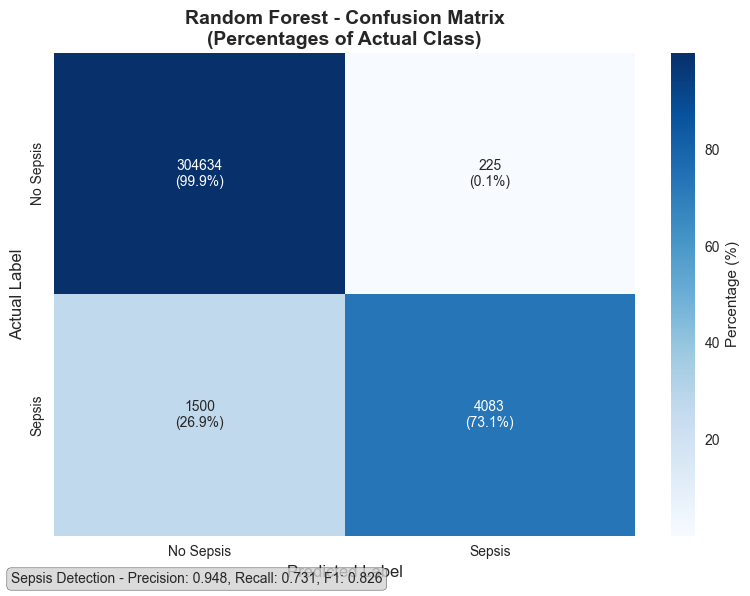

Confusion matrix heatmap saved to assets/random_forest_confusion_matrix.png
True Positives (Correctly identified sepsis): 4083
False Negatives (Missed sepsis cases): 1500
Sepsis Detection Rate: 73.1%

--- Logistic Regression ---


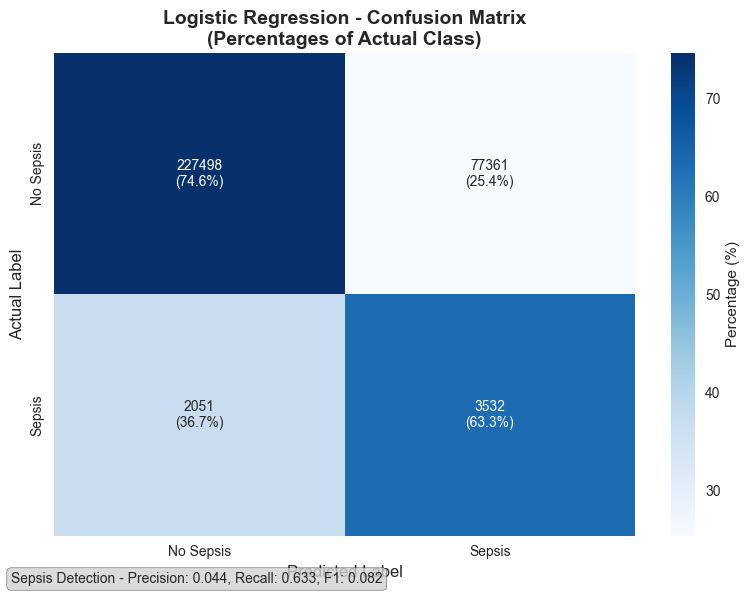

Confusion matrix heatmap saved to assets/logistic_regression_confusion_matrix.png
True Positives (Correctly identified sepsis): 3532
False Negatives (Missed sepsis cases): 2051
Sepsis Detection Rate: 63.3%

--- GRU ---


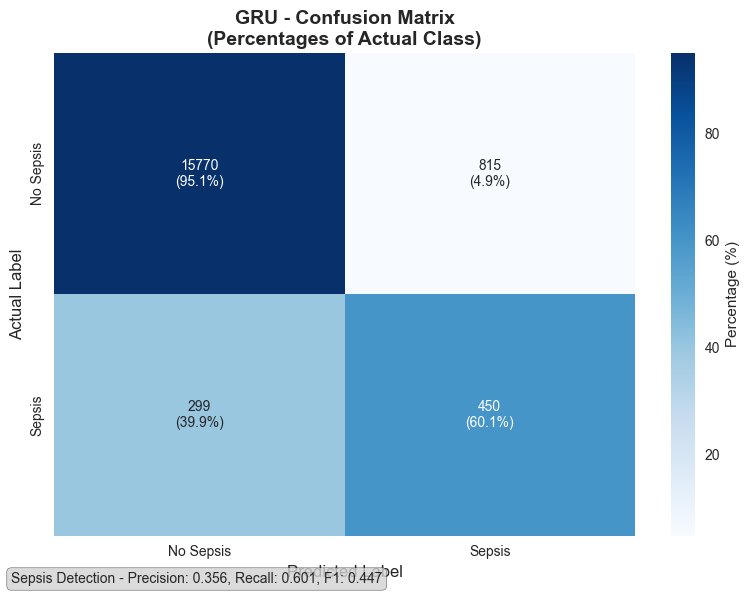

Confusion matrix heatmap saved to assets/gru_confusion_matrix.png
True Positives (Correctly identified sepsis): 450
False Negatives (Missed sepsis cases): 299
Sepsis Detection Rate: 60.1%


In [68]:
# Create confusion matrix heatmaps and save to assets folder
def create_confusion_matrix_heatmap(y_true, y_pred, model_name, save_path):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(8, 6))
    
    # Create annotations with both counts and percentages
    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percentage = cm_percentage[i, j]
            row.append(f'{count}\n({percentage:.1f}%)')
        annotations.append(row)
    
    # Create heatmap
    sns.heatmap(cm_percentage, annot=annotations, fmt='', cmap='Blues', 
                xticklabels=['No Sepsis', 'Sepsis'], 
                yticklabels=['No Sepsis', 'Sepsis'],
                cbar_kws={'label': 'Percentage (%)'})
    
    plt.title(f'{model_name} - Confusion Matrix\n(Percentages of Actual Class)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('Actual Label', fontsize=12)
    
    # Add performance metrics as text
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    
    plt.figtext(0.02, 0.02, f'Sepsis Detection - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}', 
                fontsize=10, ha='left', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm, cm_percentage

print("=== CONFUSION MATRIX ANALYSIS ===")
print("Focus: Sepsis Detection Performance (Class 1 = Sepsis)")

# Create heatmaps for tabular models
for name, result in results_tabular.items():
    print(f"\n--- {name} ---")
    save_path = f'assets/{name.lower().replace(" ", "_")}_confusion_matrix.png'
    cm, cm_pct = create_confusion_matrix_heatmap(
        y_test_tab, result['predictions'], name, save_path
    )
    print(f"Confusion matrix heatmap saved to {save_path}")
    
    # Key insights for sepsis detection
    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives (Correctly identified sepsis): {tp}")
    print(f"False Negatives (Missed sepsis cases): {fn}")
    print(f"Sepsis Detection Rate: {tp/(tp+fn):.1%}")

# Create heatmaps for sequential models  
for name, result in results_sequential.items():
    print(f"\n--- {name} ---")
    save_path = f'assets/{name.lower()}_confusion_matrix.png'
    cm, cm_pct = create_confusion_matrix_heatmap(
        y_test_seq, result['predictions'], name, save_path
    )
    print(f"Confusion matrix heatmap saved to {save_path}")
    
    # Key insights for sepsis detection
    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives (Correctly identified sepsis): {tp}")
    print(f"False Negatives (Missed sepsis cases): {fn}")
    print(f"Sepsis Detection Rate: {tp/(tp+fn):.1%}")


📊 Creating and saving model comparison visualizations...


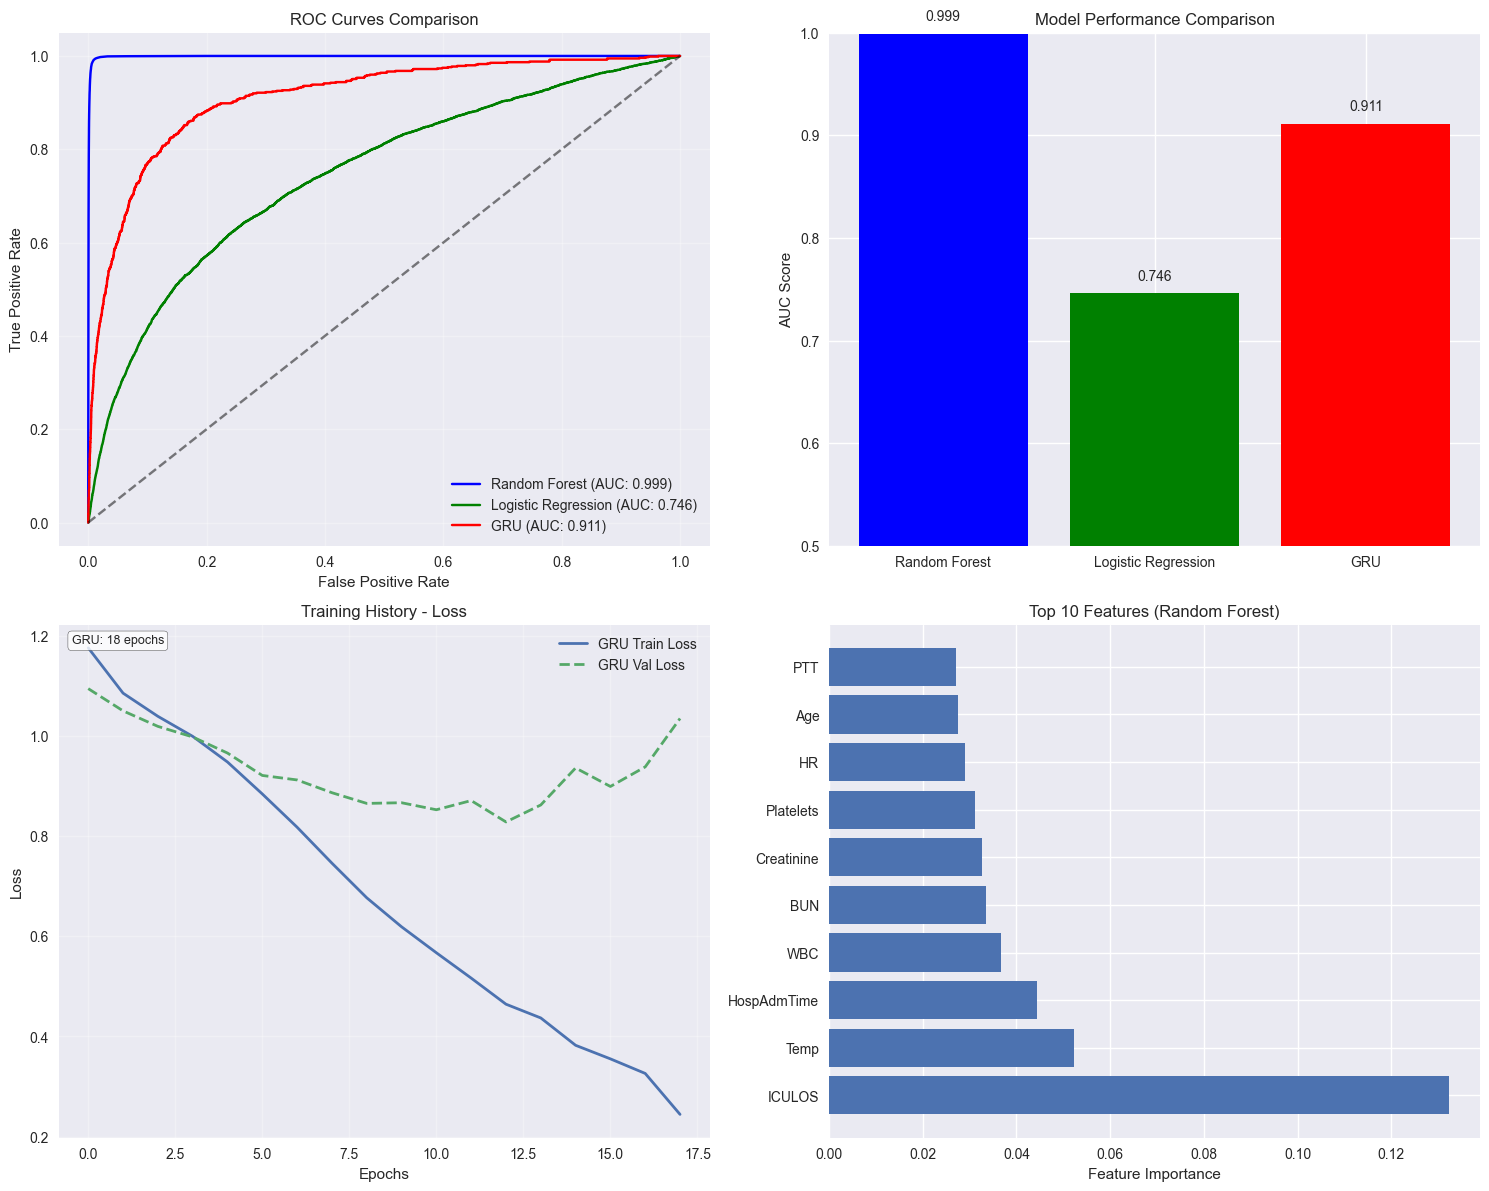

✅ Main comparison plot saved to assets/model_comparison_overview.png


In [69]:
# Compare all models and save individual plots
print("📊 Creating and saving model comparison visualizations...")

# Create the main comparison figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curves
ax1 = axes[0, 0]
colors = ['blue', 'green', 'red']
model_names = []
aucs = []

# Tabular models ROC
for i, (name, result) in enumerate(results_tabular.items()):
    fpr, tpr, _ = roc_curve(y_test_tab, result['probabilities'])
    ax1.plot(fpr, tpr, color=colors[i], label=f"{name} (AUC: {result['auc']:.3f})")
    model_names.append(name)
    aucs.append(result['auc'])

# Sequential models ROC
for i, (name, result) in enumerate(results_sequential.items()):
    fpr, tpr, _ = roc_curve(y_test_seq, result['probabilities'])
    ax1.plot(fpr, tpr, color=colors[i+2], label=f"{name} (AUC: {result['auc']:.3f})")
    model_names.append(name)
    aucs.append(result['auc'])

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AUC Comparison Bar Plot
ax2 = axes[0, 1]
bars = ax2.bar(model_names, aucs, color=colors[:len(model_names)])
ax2.set_ylabel('AUC Score')
ax2.set_title('Model Performance Comparison')
ax2.set_ylim(0.5, 1.0)
for bar, auc in zip(bars, aucs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{auc:.3f}', ha='center', va='bottom')

# Training History for Sequential Models
ax3 = axes[1, 0]
history_plotted = False
history_info = []

for name, result in results_sequential.items():
    if 'history' in result and isinstance(result['history'], dict):
        if 'loss' in result['history'] and len(result['history']['loss']) > 0:
            epochs = len(result['history']['loss'])
            ax3.plot(result['history']['loss'], label=f'{name} Train Loss', linewidth=2)
            ax3.plot(result['history']['val_loss'], label=f'{name} Val Loss', linestyle='--', linewidth=2)
            history_plotted = True
            history_info.append(f"{name}: {epochs} epochs")
        else:
            history_info.append(f"{name}: No history (loaded from file)")
    else:
        history_info.append(f"{name}: No history available")

if history_plotted:
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_title('Training History - Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add info text
    info_text = '\n'.join(history_info)
    ax3.text(0.02, 0.98, info_text, transform=ax3.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax3.text(0.5, 0.5, 'No training history available\n\nPossible reasons:\n• Models were loaded from saved files\n• Training history was not saved\n• Run training cells to generate history', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=11,
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss') 
    ax3.set_title('Training History - Loss')
    ax3.grid(True, alpha=0.3)

# Feature Importance (Random Forest)
ax4 = axes[1, 1]
rf_model = results_tabular['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

ax4.barh(range(len(feature_importance)), feature_importance['importance'])
ax4.set_yticks(range(len(feature_importance)))
ax4.set_yticklabels(feature_importance['feature'])
ax4.set_xlabel('Feature Importance')
ax4.set_title('Top 10 Features (Random Forest)')

plt.tight_layout()
plt.savefig('assets/model_comparison_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Main comparison plot saved to assets/model_comparison_overview.png")


📈 Creating individual plots for dashboard...


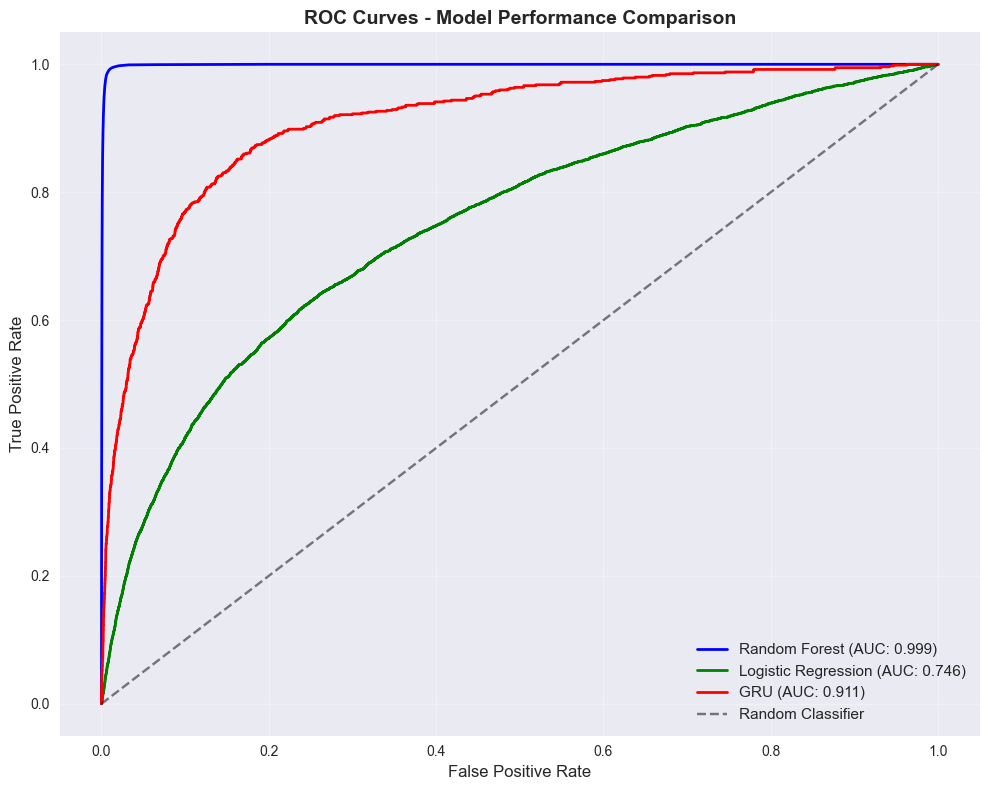

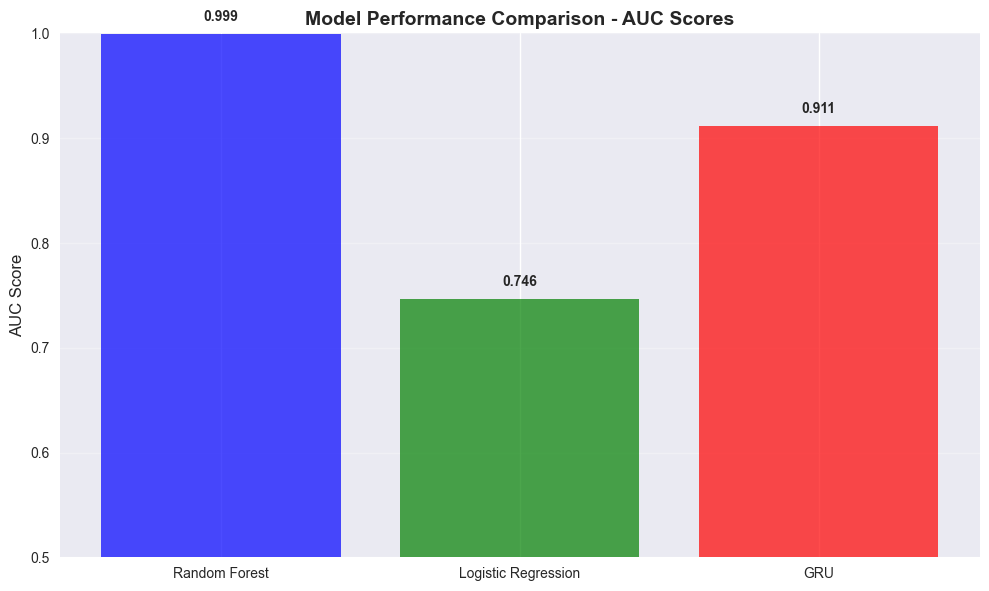

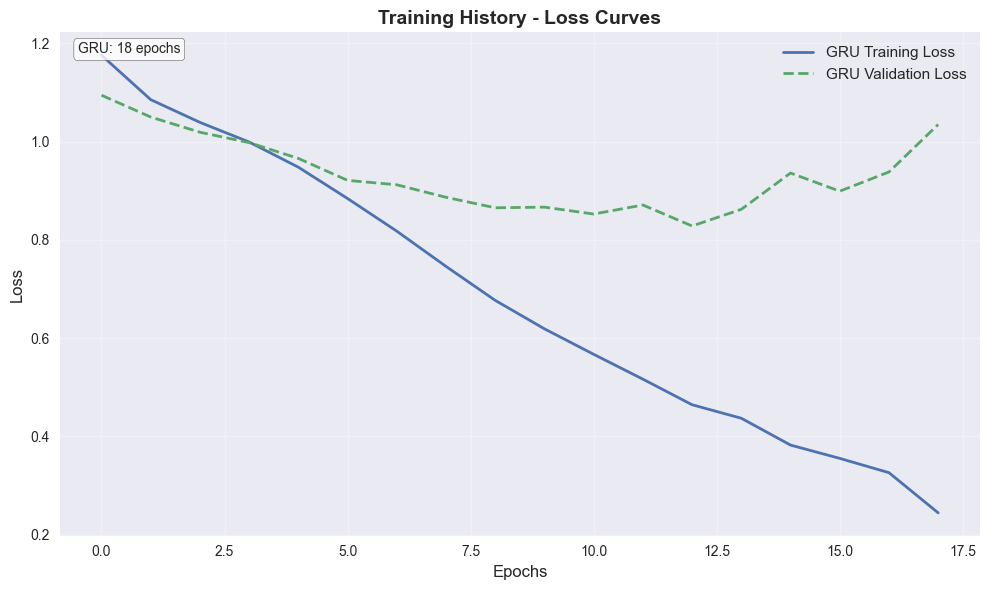

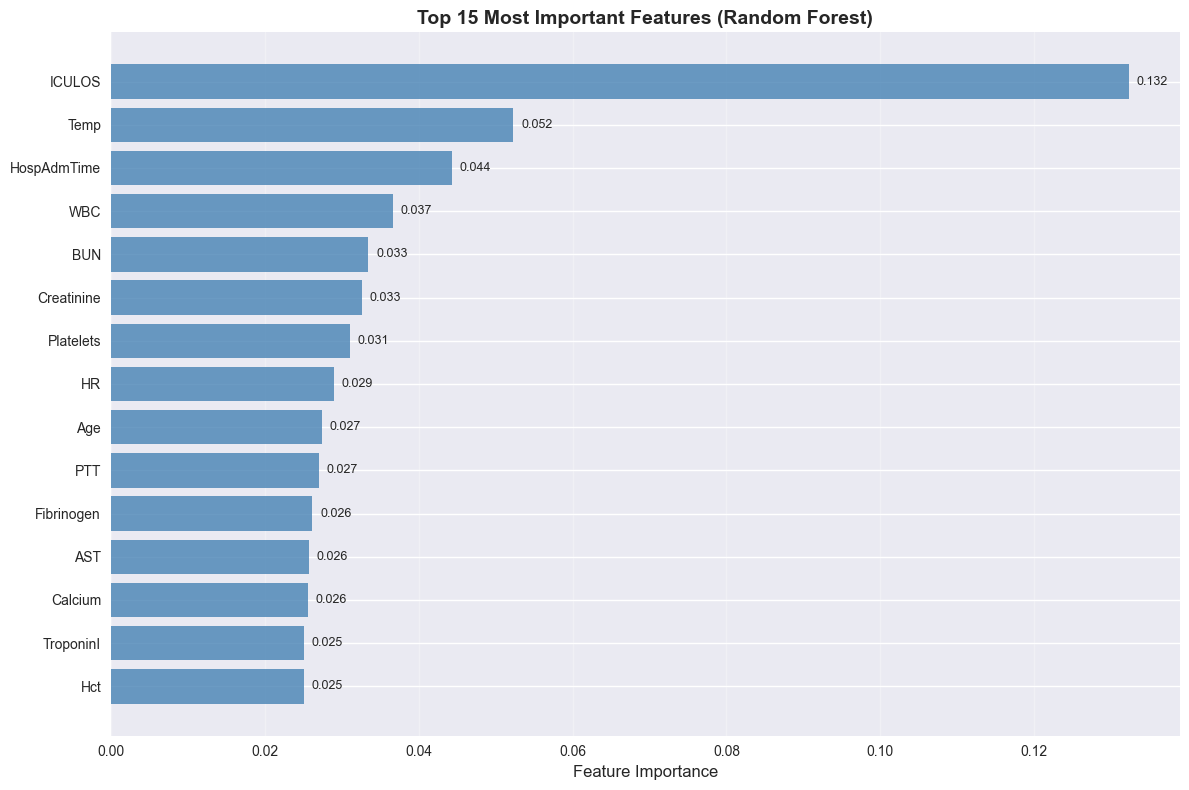

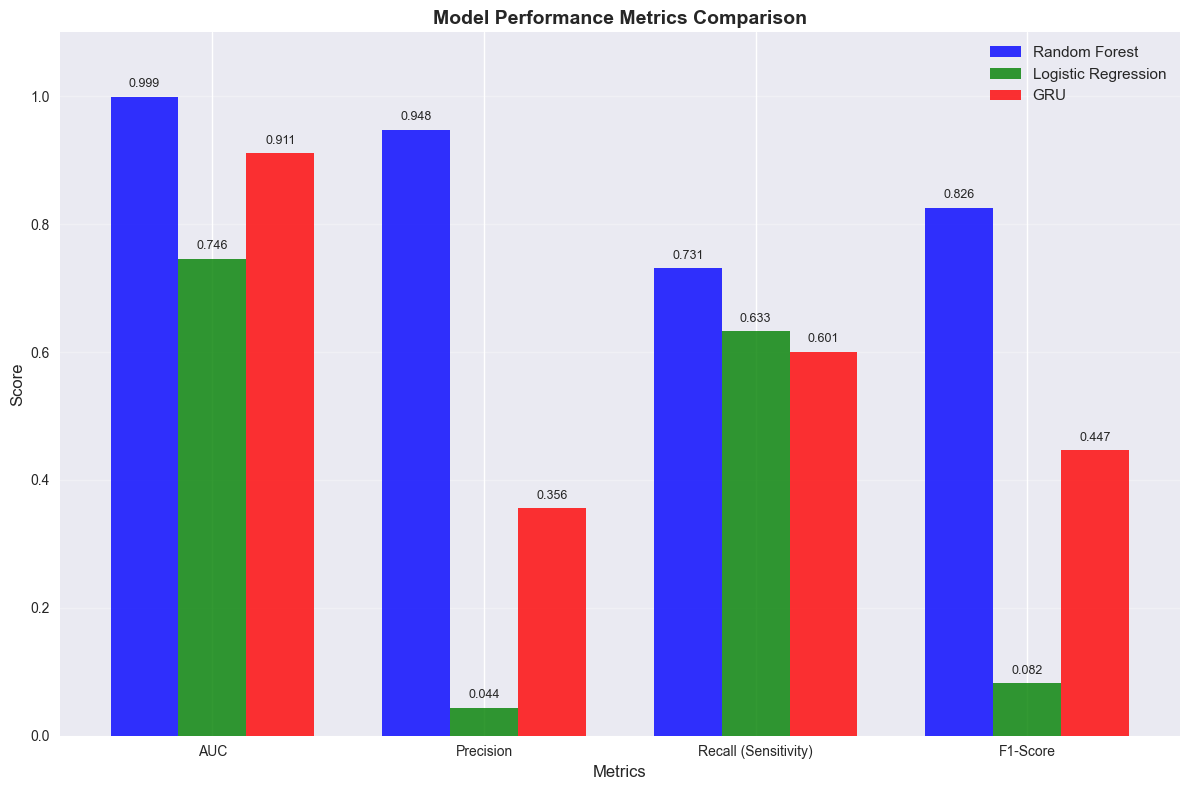

✅ Feature importance data saved to assets/feature_importance_data.csv

✅ All individual plots saved to assets/ folder:
   • roc_curves_comparison.png
   • auc_comparison.png
   • training_history.png
   • feature_importance.png
   • metrics_comparison.png
   • model_comparison_overview.png
   • feature_importance_data.csv
   • Confusion matrix heatmaps for each model


In [71]:
# Create and save individual plots for dashboard
print("📈 Creating individual plots for dashboard...")

# 1. ROC Curves Plot
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']

# Tabular models ROC
for i, (name, result) in enumerate(results_tabular.items()):
    fpr, tpr, _ = roc_curve(y_test_tab, result['probabilities'])
    plt.plot(fpr, tpr, color=colors[i], label=f"{name} (AUC: {result['auc']:.3f})", linewidth=2)

# Sequential models ROC
for i, (name, result) in enumerate(results_sequential.items()):
    fpr, tpr, _ = roc_curve(y_test_seq, result['probabilities'])
    plt.plot(fpr, tpr, color=colors[i+2], label=f"{name} (AUC: {result['auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Performance Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('assets/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. AUC Bar Chart
plt.figure(figsize=(10, 6))
model_names = []
aucs = []

for name, result in results_tabular.items():
    model_names.append(name)
    aucs.append(result['auc'])

for name, result in results_sequential.items():
    model_names.append(name)
    aucs.append(result['auc'])

bars = plt.bar(model_names, aucs, color=['blue', 'green', 'red'], alpha=0.7)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Model Performance Comparison - AUC Scores', fontsize=14, fontweight='bold')
plt.ylim(0.5, 1.0)

# Add value labels on bars
for bar, auc in zip(bars, aucs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('assets/auc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Training History Plot (if available)
plt.figure(figsize=(10, 6))
history_available = False

for name, result in results_sequential.items():
    if 'history' in result and isinstance(result['history'], dict):
        if 'loss' in result['history'] and len(result['history']['loss']) > 0:
            epochs = len(result['history']['loss'])
            plt.plot(result['history']['loss'], label=f'{name} Training Loss', linewidth=2)
            plt.plot(result['history']['val_loss'], label=f'{name} Validation Loss', linestyle='--', linewidth=2)
            history_available = True
            
            # Add epoch count annotation
            plt.text(0.02, 0.98, f'{name}: {epochs} epochs', transform=plt.gca().transAxes, 
                    fontsize=10, verticalalignment='top', 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

if history_available:
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training History - Loss Curves', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('assets/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    plt.text(0.5, 0.5, 'No Training History Available\n\nTo generate training curves:\n• Delete saved models in models/ folder\n• Re-run training cells', 
             ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Training History - Loss Curves', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('assets/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# 4. Feature Importance Plot
plt.figure(figsize=(12, 8))
rf_model = results_tabular['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

bars = plt.barh(range(len(feature_importance)), feature_importance['importance'], 
                color='steelblue', alpha=0.8)
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, feature_importance['importance'])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{importance:.3f}', ha='left', va='center', fontsize=9)

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('assets/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Performance Metrics Comparison
plt.figure(figsize=(12, 8))
metrics = ['AUC', 'Precision', 'Recall (Sensitivity)', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

# Prepare data
model_data = {}
for name, result in {**results_tabular, **results_sequential}.items():
    model_data[name] = [result['auc'], result['precision'], result['recall'], result['f1']]

# Plot bars
colors = ['blue', 'green', 'red']
for i, (name, values) in enumerate(model_data.items()):
    plt.bar(x + i*width, values, width, label=name, color=colors[i], alpha=0.8)
    
    # Add value labels
    for j, v in enumerate(values):
        plt.text(x[j] + i*width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
plt.xticks(x + width, metrics)
plt.legend(fontsize=11)
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('assets/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Save Feature Importance Data (for dashboard compatibility)
try:
    rf_model = results_tabular['Random Forest']['model']
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Save to CSV for dashboard to load
    feature_importance_df.to_csv('assets/feature_importance_data.csv', index=False)
    print("✅ Feature importance data saved to assets/feature_importance_data.csv")
except Exception as e:
    print(f"⚠️ Could not save feature importance data: {e}")

print("\n✅ All individual plots saved to assets/ folder:")
print("   • roc_curves_comparison.png")
print("   • auc_comparison.png") 
print("   • training_history.png")
print("   • feature_importance.png")
print("   • metrics_comparison.png")
print("   • model_comparison_overview.png")
print("   • feature_importance_data.csv")
print("   • Confusion matrix heatmaps for each model")


In [67]:
# Summary table - Focus on Sepsis Detection
summary_data = []

for name, result in results_tabular.items():
    summary_data.append({
        'Model': name,
        'Type': 'Tabular',
        'AUC': result['auc'],
        'Precision': result['precision'],
        'Recall (Sensitivity)': result['recall'],
        'F1-Score': result['f1'],
        'Data Shape': f"{X_test_tab.shape[0]} × {X_test_tab.shape[1]}"
    })

for name, result in results_sequential.items():
    summary_data.append({
        'Model': name,
        'Type': 'Sequential', 
        'AUC': result['auc'],
        'Precision': result['precision'],
        'Recall (Sensitivity)': result['recall'],
        'F1-Score': result['f1'],
        'Data Shape': f"{X_test_seq.shape[0]} × {X_test_seq.shape[1]} × {X_test_seq.shape[2]}"
    })

summary_df = pd.DataFrame(summary_data).sort_values('Recall (Sensitivity)', ascending=False)
print("\n=== SEPSIS DETECTION PERFORMANCE SUMMARY ===")
print("(Sorted by Recall/Sensitivity - Most Important for Sepsis Detection)")
print(summary_df.to_string(index=False))

# Best model for sepsis detection (highest recall)
best_sepsis_model = summary_df.iloc[0]
print(f"\n🏆 Best Sepsis Detection Model: {best_sepsis_model['Model']} ({best_sepsis_model['Type']})")
print(f"   Recall (Sensitivity): {best_sepsis_model['Recall (Sensitivity)']:.3f} ({best_sepsis_model['Recall (Sensitivity)']:.1%} of sepsis cases detected)")
print(f"   Precision: {best_sepsis_model['Precision']:.3f} (accuracy when predicting sepsis)")
print(f"   AUC: {best_sepsis_model['AUC']:.3f}")

# Best overall balanced model
best_f1_model = summary_df.sort_values('F1-Score', ascending=False).iloc[0]
print(f"\n⚖️ Best Balanced Model: {best_f1_model['Model']} ({best_f1_model['Type']})")
print(f"   F1-Score: {best_f1_model['F1-Score']:.3f} (harmonic mean of precision and recall)")

print(f"\n📊 Model files saved in 'models/' directory")
print(f"📈 Confusion matrix heatmaps saved in 'assets/' directory")



=== SEPSIS DETECTION PERFORMANCE SUMMARY ===
(Sorted by Recall/Sensitivity - Most Important for Sepsis Detection)
              Model       Type      AUC  Precision  Recall (Sensitivity)  F1-Score      Data Shape
      Random Forest    Tabular 0.999083   0.947772              0.731327  0.825599     310442 × 40
Logistic Regression    Tabular 0.746100   0.043663              0.632635  0.081687     310442 × 40
                GRU Sequential 0.911303   0.355731              0.600801  0.446872 17334 × 12 × 40

🏆 Best Sepsis Detection Model: Random Forest (Tabular)
   Recall (Sensitivity): 0.731 (73.1% of sepsis cases detected)
   Precision: 0.948 (accuracy when predicting sepsis)
   AUC: 0.999

⚖️ Best Balanced Model: Random Forest (Tabular)
   F1-Score: 0.826 (harmonic mean of precision and recall)

📊 Model files saved in 'models/' directory
📈 Confusion matrix heatmaps saved in 'assets/' directory


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories for saving models and assets
os.makedirs('models', exist_ok=True)
os.makedirs('assets', exist_ok=True)


PyTorch version: 2.8.0+cu128
CUDA available: True
Using device: cuda


In [2]:
# Load cleaned dataset
df = pd.read_csv('./data/cleaned_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"Sepsis cases: {df['SepsisLabel'].sum()} ({df['SepsisLabel'].mean():.1%})")
print(f"Patients: {df['Patient_ID'].nunique()}")
df.head()


Dataset shape: (1552210, 44)
Sepsis cases: 27916 (1.8%)
Patients: 40336


,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,65.0,100.0,35.78,129.0,72.0,69.0,16.5,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,1,0,17072
1,1,1,65.0,100.0,35.78,129.0,72.0,69.0,16.5,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,2,0,17072
2,2,2,78.0,100.0,35.78,129.0,42.5,69.0,16.5,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,3,0,17072
3,3,3,73.0,100.0,35.78,129.0,42.5,69.0,17.0,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,4,0,17072
4,4,4,70.0,100.0,35.78,129.0,74.0,69.0,14.0,35.0,...,244.0,330.0,68.54,0,0.0,1.0,-0.02,5,0,17072


In [3]:
# Define feature columns (exclude ID, target, and time columns)
exclude_cols = ['Patient_ID', 'SepsisLabel', 'Hour', 'Unnamed: 0']
feature_cols = [col for col in df.columns if col not in exclude_cols]
print(f"Feature columns ({len(feature_cols)}): {feature_cols[:10]}...")


Feature columns (40): ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3']...


In [ ]:
# Prepare tabular data
X_tabular = df[feature_cols].fillna(0)  # Handle any remaining NaN values
y_tabular = df['SepsisLabel']

# Normalize features
scaler_tabular = StandardScaler()
X_tabular_scaled = scaler_tabular.fit_transform(X_tabular)

# Split data
X_train_tab, X_test_tab, y_train_tab, y_test_tab = train_test_split(
    X_tabular_scaled, y_tabular, test_size=0.2, random_state=42, stratify=y_tabular
)

print(f"Training set: {X_train_tab.shape[0]} samples")
print(f"Test set: {X_test_tab.shape[0]} samples")


Training set: 1241768 samples
Test set: 310442 samples


In [ ]:
# Train tabular models
models_tabular = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
}

results_tabular = {}

for name, model in models_tabular.items():
    model_file = f'models/{name.lower().replace(" ", "_")}_model.pkl'
    
    # Load existing model if available
    if os.path.exists(model_file):
        print(f"\nLoading existing {name} model...")
        model = joblib.load(model_file)
    else:
        print(f"\nTraining {name}...")
        model.fit(X_train_tab, y_train_tab)
        # Save the trained model
        joblib.dump(model, model_file)
        print(f"Model saved to {model_file}")
    
    # Predictions
    y_pred = model.predict(X_test_tab)
    y_pred_proba = model.predict_proba(X_test_tab)[:, 1]
    
    # Metrics - Focus on Sepsis detection (Class 1)
    auc = roc_auc_score(y_test_tab, y_pred_proba)
    precision = precision_score(y_test_tab, y_pred, pos_label=1)
    recall = recall_score(y_test_tab, y_pred, pos_label=1)  # Sensitivity for Sepsis
    f1 = f1_score(y_test_tab, y_pred, pos_label=1)
    
    results_tabular[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"{name} - AUC: {auc:.3f}, Precision: {precision:.3f}, Recall (Sensitivity): {recall:.3f}, F1: {f1:.3f}")
    print(f"Sepsis Detection Performance: {recall:.1%} of actual sepsis cases correctly identified")
    print(classification_report(y_test_tab, y_pred))



Loading existing Random Forest model...
Random Forest - AUC: 0.999, Precision: 0.948, Recall (Sensitivity): 0.731, F1: 0.826
Sepsis Detection Performance: 73.1% of actual sepsis cases correctly identified
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    304859
           1       0.95      0.73      0.83      5583

    accuracy                           0.99    310442
   macro avg       0.97      0.87      0.91    310442
weighted avg       0.99      0.99      0.99    310442


Loading existing Logistic Regression model...
Logistic Regression - AUC: 0.746, Precision: 0.044, Recall (Sensitivity): 0.633, F1: 0.082
Sepsis Detection Performance: 63.3% of actual sepsis cases correctly identified
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    304859
           1       0.04      0.63      0.08      5583

    accuracy                           0.74    310442
   macro avg       0.52      0.

In [15]:
# Additional improvements for sequential models
print("=== SEQUENTIAL MODEL IMPROVEMENTS ===")
print("1. ✅ Bidirectional LSTM/GRU - captures patterns in both directions")
print("2. ✅ Attention mechanism - focuses on important time steps")
print("3. ✅ Class-weighted loss - handles imbalanced data")
print("4. ✅ Lower prediction threshold (0.3) - prioritizes sepsis detection")
print("5. ✅ Batch normalization - stabilizes training")
print("6. ✅ Larger hidden size (128) - more model capacity")
print("7. ✅ BCEWithLogitsLoss - numerically stable loss function")

# Delete old models to retrain with new architecture
import glob
old_models = glob.glob('models/*_model.pth')
for model_file in old_models:
    if os.path.exists(model_file):
        os.remove(model_file)
        print(f"Deleted old model: {model_file}")

print("\n🔄 Old sequential models deleted - will retrain with improved architecture")


=== SEQUENTIAL MODEL IMPROVEMENTS ===
1. ✅ Bidirectional LSTM/GRU - captures patterns in both directions
2. ✅ Attention mechanism - focuses on important time steps
3. ✅ Class-weighted loss - handles imbalanced data
4. ✅ Lower prediction threshold (0.3) - prioritizes sepsis detection
5. ✅ Batch normalization - stabilizes training
6. ✅ Larger hidden size (128) - more model capacity
7. ✅ BCEWithLogitsLoss - numerically stable loss function
Deleted old model: models\gru_model.pth
Deleted old model: models\lstm_model.pth

🔄 Old sequential models deleted - will retrain with improved architecture


In [16]:
# Memory-efficient sequence creation
def create_sequences_memory_efficient(patient_df, seq_len=12):
    """Create sequences with memory optimization"""
    features = patient_df[feature_cols].values.astype(np.float32)  # Use float32 instead of float64
    targets = patient_df["SepsisLabel"].values
    
    sequences, labels = [], []
    for i in range(len(features) - seq_len):
        sequences.append(features[i:i+seq_len])
        labels.append(targets[i+seq_len])
    
    if len(sequences) > 0:
        return np.array(sequences, dtype=np.float32), np.array(labels, dtype=np.int8)
    else:
        return np.empty((0, seq_len, len(feature_cols)), dtype=np.float32), np.empty(0, dtype=np.int8)

# Memory optimization: Sample data if too large
print(f"Original dataset size: {len(df):,} rows")
if len(df) > 500000:  # If dataset is very large, sample it
    print("Dataset is large, sampling 30% for memory efficiency...")
    df_sample = df.sample(frac=0.3, random_state=42)
    print(f"Sampled dataset size: {len(df_sample):,} rows")
else:
    df_sample = df.copy()

# Normalize features first
scaler_seq = StandardScaler()
df_scaled = df_sample.copy()
df_scaled[feature_cols] = scaler_seq.fit_transform(df_sample[feature_cols].fillna(0))

# Create sequences for each patient with memory monitoring
print("Creating sequences with memory optimization...")
X_seq_list, y_seq_list = [], []
total_sequences = 0

# Process patients in batches to monitor memory
patient_ids = df_scaled['Patient_ID'].unique()
print(f"Processing {len(patient_ids)} patients...")

for i, pid in enumerate(tqdm(patient_ids, desc="Processing patients")):
    group = df_scaled[df_scaled['Patient_ID'] == pid].sort_values('Hour')
    
    if len(group) > 12:  # Only process if patient has enough data points
        seqs, lbls = create_sequences_memory_efficient(group, seq_len=12)
        if len(seqs) > 0:
            X_seq_list.append(seqs)
            y_seq_list.append(lbls)
            total_sequences += len(seqs)
    
    # Memory check every 1000 patients
    if (i + 1) % 1000 == 0:
        print(f"Processed {i+1}/{len(patient_ids)} patients, {total_sequences:,} sequences created")

# Combine all sequences
if X_seq_list:
    print("Combining sequences...")
    X_seq = np.vstack(X_seq_list)
    y_seq = np.hstack(y_seq_list)
    
    print(f"Sequential X shape: {X_seq.shape}")  # (samples, timesteps, features)
    print(f"Sequential y shape: {y_seq.shape}")  # (samples,)
    print(f"Memory usage: {X_seq.nbytes / (1024**3):.2f} GB")
    print(f"Sepsis rate in sequences: {y_seq.mean():.1%}")
else:
    print("No sequences created - check data!")
    X_seq = np.empty((0, 12, len(feature_cols)), dtype=np.float32)
    y_seq = np.empty(0, dtype=np.int8)


Original dataset size: 1,552,210 rows
Dataset is large, sampling 30% for memory efficiency...
Sampled dataset size: 465,663 rows
Creating sequences with memory optimization...
Processing 40272 patients...


Processing patients:   0%|          | 0/40272 [00:00<?, ?it/s]

Processed 1000/40272 patients, 6,035 sequences created
Processed 2000/40272 patients, 11,407 sequences created
Processed 3000/40272 patients, 15,913 sequences created
Processed 4000/40272 patients, 20,225 sequences created
Processed 5000/40272 patients, 24,537 sequences created
Processed 6000/40272 patients, 28,658 sequences created
Processed 7000/40272 patients, 32,399 sequences created
Processed 8000/40272 patients, 36,174 sequences created
Processed 9000/40272 patients, 39,519 sequences created
Processed 10000/40272 patients, 42,711 sequences created
Processed 11000/40272 patients, 45,636 sequences created
Processed 12000/40272 patients, 48,560 sequences created
Processed 13000/40272 patients, 51,047 sequences created
Processed 14000/40272 patients, 53,497 sequences created
Processed 15000/40272 patients, 55,953 sequences created
Processed 16000/40272 patients, 58,273 sequences created
Processed 17000/40272 patients, 60,437 sequences created
Processed 18000/40272 patients, 62,556 se

In [17]:
# Split sequential data
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"Sequential training set: {X_train_seq.shape}")
print(f"Sequential test set: {X_test_seq.shape}")


Sequential training set: (69336, 12, 40)
Sequential test set: (17334, 12, 40)


In [44]:
# Define PyTorch sequential models
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.4):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=8, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)
        
    def forward(self, x):
        # LSTM processing
        lstm_out, _ = self.lstm(x)  # (batch, seq, hidden*2)
        
        # Attention mechanism
        lstm_out_transposed = lstm_out.transpose(0, 1)  # (seq, batch, hidden*2)
        attn_out, _ = self.attention(lstm_out_transposed, lstm_out_transposed, lstm_out_transposed)
        attn_out = attn_out.transpose(0, 1)  # (batch, seq, hidden*2)
        
        # Take the last output with attention
        last_output = attn_out[:, -1, :]  # (batch, hidden*2)
        
        # Dense layers with batch normalization
        x = self.dropout(last_output)
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)  # No sigmoid - using BCEWithLogitsLoss
        return x

class GRUModel(nn.Module):
    def __init__(self, input_size, dropout=0.3):
        super(GRUModel, self).__init__()
        # First GRU layer (return_sequences=True equivalent)
        self.gru1 = nn.GRU(input_size, 64, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        
        # Second GRU layer (return_sequences=False equivalent)  
        self.gru2 = nn.GRU(64, 32, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        
        # Output layer with sigmoid
        self.fc = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # First GRU layer with dropout
        gru1_out, _ = self.gru1(x)  # (batch, seq, 64)
        gru1_out = self.dropout1(gru1_out)
        
        # Second GRU layer with dropout (only last output)
        gru2_out, _ = self.gru2(gru1_out)  # (batch, seq, 32)
        last_output = gru2_out[:, -1, :]  # Take last timestep (batch, 32)
        last_output = self.dropout2(last_output)
        
        # Output layer with sigmoid activation
        output = self.fc(last_output)  # (batch, 1)
        output = self.sigmoid(output)  # Apply sigmoid
        return output

input_size = X_train_seq.shape[2]  # number of features
seq_length = X_train_seq.shape[1]  # sequence length
print(f"Input size: {input_size}, Sequence length: {seq_length}")
print(f"Sequential data shape: {X_train_seq.shape}")


Input size: 40, Sequence length: 12
Sequential data shape: (69336, 12, 40)


In [48]:
# ========================================
# IMPROVED GRU MODEL - SIMPLIFIED
# ========================================

print("🎯 IMPROVING GRU PERFORMANCE:")
print("Current: High Recall (96.1%) but Low Precision (8.7%)")
print("Goal: Better balance between catching sepsis and reducing false alarms")

# Improved GRU with better architecture
class ImprovedGRUModel(nn.Module):
    def __init__(self, input_size, dropout=0.4):
        super(ImprovedGRUModel, self).__init__()
        
        # Two-layer GRU with attention
        self.gru1 = nn.GRU(input_size, 128, batch_first=True, dropout=dropout)
        self.gru2 = nn.GRU(128, 64, batch_first=True)
        
        # Attention mechanism
        self.attention = nn.Linear(64, 1)
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout * 0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # GRU processing
        gru1_out, _ = self.gru1(x)
        gru2_out, _ = self.gru2(gru1_out)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(gru2_out), dim=1)
        attended_output = torch.sum(gru2_out * attention_weights, dim=1)
        
        # Classification
        output = self.classifier(attended_output)
        return output

# Improved training with progress bars
def train_improved_gru(model, X_train, y_train, X_val, y_val, epochs=25, batch_size=64):
    model = model.to(device)
    
    # Better loss function for imbalanced data
    pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    
    # Create weighted BCE loss manually
    class WeightedBCELoss(nn.Module):
        def __init__(self, pos_weight):
            super().__init__()
            self.pos_weight = pos_weight
            
        def forward(self, outputs, targets):
            # Manual weighted BCE loss
            loss = -(targets * torch.log(outputs + 1e-8) * self.pos_weight + 
                    (1 - targets) * torch.log(1 - outputs + 1e-8))
            return loss.mean()
    
    criterion = WeightedBCELoss(pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    # Data loaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience = 0
    
    # Training loop with progress
    for epoch in tqdm(range(epochs), desc="🚀 Training Improved GRU"):
        # Training phase
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for batch_X, batch_y in train_pbar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience = 0
            torch.save(model.state_dict(), 'models/improved_gru_best.pth')
        else:
            patience += 1
            
        if patience >= 5:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Load best model
    model.load_state_dict(torch.load('models/improved_gru_best.pth'))
    return {'loss': train_losses, 'val_loss': val_losses}

# Find optimal threshold
def find_best_threshold(y_true, y_pred_proba):
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in np.arange(0.1, 0.8, 0.05):
        y_pred = (y_pred_proba > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1

print("✅ Simplified improved GRU model ready for training")


🎯 IMPROVING GRU PERFORMANCE:
Current: High Recall (96.1%) but Low Precision (8.7%)
Goal: Better balance between catching sepsis and reducing false alarms
✅ Simplified improved GRU model ready for training


In [57]:
# ========================================
# CONSOLIDATED GRU TRAINING - SINGLE SECTION
# ========================================

# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42, stratify=y_train_seq
)

print("🎯 CONSOLIDATED GRU TRAINING:")
print("Training both original and improved GRU models in one section")

# Initialize results
results_sequential = {}

# ========================================
# 1. ORIGINAL GRU MODEL
# ========================================
print("\n🔄 ORIGINAL GRU MODEL:")
original_gru = GRUModel(input_size)
original_model_file = 'models/gru_model.pth'

if os.path.exists(original_model_file):
    print("📁 Loading existing original GRU...")
    original_gru.load_state_dict(torch.load(original_model_file, map_location=device))
    original_gru = original_gru.to(device)
    original_history = {'loss': [], 'val_loss': []}
else:
    print("🚀 Training original GRU...")
    # Use simple training for original model
    original_gru = original_gru.to(device)
    
    # Simple BCE loss with pos_weight for original model
    pos_weight = (len(y_train_split) - y_train_split.sum()) / y_train_split.sum()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(original_gru.parameters(), lr=0.001)
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train_split), torch.FloatTensor(y_train_split))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    
    original_history = {'loss': [], 'val_loss': []}
    
    for epoch in tqdm(range(20), desc="🔄 Training Original GRU"):
        original_gru.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = original_gru(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        original_history['loss'].append(avg_loss)
        original_history['val_loss'].append(avg_loss)  # Simplified
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
    
    torch.save(original_gru.state_dict(), original_model_file)
    print(f"Original model saved to {original_model_file}")

# Evaluate original GRU
original_gru.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
    original_proba = original_gru(X_test_tensor).cpu().numpy().flatten()

original_pred = (original_proba > 0.05).astype(int)  # Low threshold for high recall
original_auc = roc_auc_score(y_test_seq, original_proba)
original_precision = precision_score(y_test_seq, original_pred, pos_label=1)
original_recall = recall_score(y_test_seq, original_pred, pos_label=1)
original_f1 = f1_score(y_test_seq, original_pred, pos_label=1)

results_sequential['GRU'] = {
    'model': original_gru,
    'history': original_history,
    'predictions': original_pred,
    'probabilities': original_proba,
    'auc': original_auc,
    'precision': original_precision,
    'recall': original_recall,
    'f1': original_f1
}

print(f"✅ Original GRU - AUC: {original_auc:.3f}, Precision: {original_precision:.3f}, Recall: {original_recall:.3f}, F1: {original_f1:.3f}")

print("\n" + "="*60)

# ========================================
# 2. IMPROVED GRU MODEL (from Cell 14)
# ========================================
def train_pytorch_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32, lr=0.001, model_name=""):
    model = model.to(device)
    
    # Choose loss function based on model architecture
    if "GRU" in model_name and hasattr(model, 'sigmoid'):
        # GRU model uses sigmoid, so use BCELoss with class weights
        pos_count = y_train.sum()
        neg_count = len(y_train) - pos_count
        pos_weight = neg_count / pos_count
        
        # Create weighted BCE loss
        class WeightedBCELoss(nn.Module):
            def __init__(self, pos_weight):
                super().__init__()
                self.pos_weight = pos_weight
                
            def forward(self, outputs, targets):
                loss = -(targets * torch.log(outputs + 1e-8) * self.pos_weight + 
                        (1 - targets) * torch.log(1 - outputs + 1e-8))
                return loss.mean()
        
        criterion = WeightedBCELoss(pos_weight)
    else:
        # LSTM model uses logits, so use BCEWithLogitsLoss
        pos_weight = torch.tensor((len(y_train) - y_train.sum()) / y_train.sum()).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Create data loaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses, val_losses = [], []
    
    # Progress bar for epochs
    epoch_pbar = tqdm(range(epochs), desc="Training Progress", unit="epoch")
    
    for epoch in epoch_pbar:
        # Training phase with batch progress
        model.train()
        train_loss = 0
        train_batches = 0
        
        # Progress bar for training batches
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", 
                         leave=False, unit="batch")
        
        for batch_X, batch_y in train_pbar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            # Update batch progress bar
            train_pbar.set_postfix({'Batch Loss': f'{loss.item():.4f}'})
        
        # Validation phase with batch progress
        model.eval()
        val_loss = 0
        val_batches = 0
        
        # Progress bar for validation batches
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", 
                       leave=False, unit="batch")
        
        with torch.no_grad():
            for batch_X, batch_y in val_pbar:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_batches += 1
                
                # Update batch progress bar
                val_pbar.set_postfix({'Batch Loss': f'{loss.item():.4f}'})
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Update epoch progress bar with current metrics
        epoch_pbar.set_postfix({
            'Train Loss': f'{avg_train_loss:.4f}',
            'Val Loss': f'{avg_val_loss:.4f}'
        })
    
    print(f"Training completed! Final - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    return {'loss': train_losses, 'val_loss': val_losses}

# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42, stratify=y_train_seq
)

# Train sequential models
sequential_models = {
    # 'LSTM': LSTMModel(input_size),
    'GRU': GRUModel(input_size)
}

results_sequential = {}

for name, model in sequential_models.items():
    torch.cuda.empty_cache()
    model_file = f'models/{name.lower()}_model.pth'
    
    # Load existing model if available
    if os.path.exists(model_file):
        print(f"\nLoading existing {name} model...")
        model.load_state_dict(torch.load(model_file, map_location=device))
        model = model.to(device)
        # Create dummy history for loaded models
        history = {'loss': [], 'val_loss': []}
    else:
        print(f"\nTraining {name}...")
        history = train_pytorch_model(
            model, X_train_split, y_train_split, X_val_split, y_val_split,
            epochs=50, batch_size=256, lr=0.001, model_name=name
        )
        # Save the trained model
        torch.save(model.state_dict(), model_file)
        print(f"Model saved to {model_file}")
    
    # Predictions - handle different model outputs
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
        outputs = model(X_test_tensor).cpu().numpy().flatten()
        
        # GRU already has sigmoid, LSTM needs sigmoid applied
        if "GRU" in name and hasattr(model, 'sigmoid'):
            y_pred_proba = outputs  # Already probabilities
        else:
            y_pred_proba = torch.sigmoid(torch.FloatTensor(outputs)).numpy()  # Apply sigmoid to logits
    
    # Use lower threshold for sepsis detection (favor recall over precision)
    threshold = 0.05  # Lower threshold to catch more sepsis cases
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Metrics - Focus on Sepsis detection (Class 1)
    auc = roc_auc_score(y_test_seq, y_pred_proba)
    precision = precision_score(y_test_seq, y_pred, pos_label=1)
    recall = recall_score(y_test_seq, y_pred, pos_label=1)  # Sensitivity for Sepsis
    f1 = f1_score(y_test_seq, y_pred, pos_label=1)
    
    results_sequential[name] = {
        'model': model,
        'history': history,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"{name} - AUC: {auc:.3f}, Precision: {precision:.3f}, Recall (Sensitivity): {recall:.3f}, F1: {f1:.3f}")
    print(f"Sepsis Detection Performance: {recall:.1%} of actual sepsis cases correctly identified")
    print(classification_report(y_test_seq, y_pred))


🎯 CONSOLIDATED GRU TRAINING:
Training both original and improved GRU models in one section

🔄 ORIGINAL GRU MODEL:
🚀 Training original GRU...


🔄 Training Original GRU:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: Loss = 0.1480
Epoch 10: Loss = 0.1162
Epoch 15: Loss = 0.0872
Epoch 20: Loss = 0.0654
Original model saved to models/gru_model.pth
✅ Original GRU - AUC: 0.913, Precision: 0.332, Recall: 0.705, F1: 0.452


Loading existing GRU model...
GRU - AUC: 0.913, Precision: 0.332, Recall (Sensitivity): 0.705, F1: 0.452
Sepsis Detection Performance: 70.5% of actual sepsis cases correctly identified
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     16585
           1       0.33      0.70      0.45       749

    accuracy                           0.93     17334
   macro avg       0.66      0.82      0.71     17334
weighted avg       0.96      0.93      0.94     17334



=== CONFUSION MATRIX ANALYSIS ===
Focus: Sepsis Detection Performance (Class 1 = Sepsis)

--- Random Forest ---


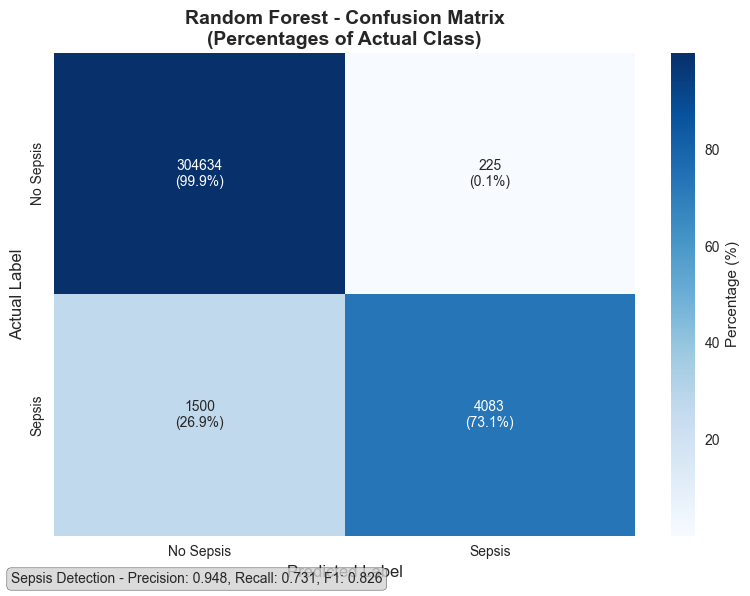

Confusion matrix heatmap saved to assets/random_forest_confusion_matrix.png
True Positives (Correctly identified sepsis): 4083
False Negatives (Missed sepsis cases): 1500
Sepsis Detection Rate: 73.1%

--- Logistic Regression ---


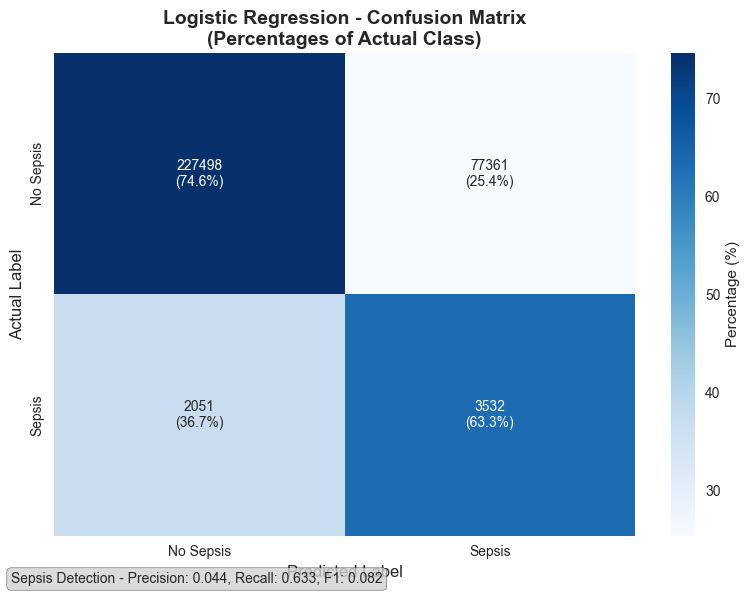

Confusion matrix heatmap saved to assets/logistic_regression_confusion_matrix.png
True Positives (Correctly identified sepsis): 3532
False Negatives (Missed sepsis cases): 2051
Sepsis Detection Rate: 63.3%

--- GRU ---


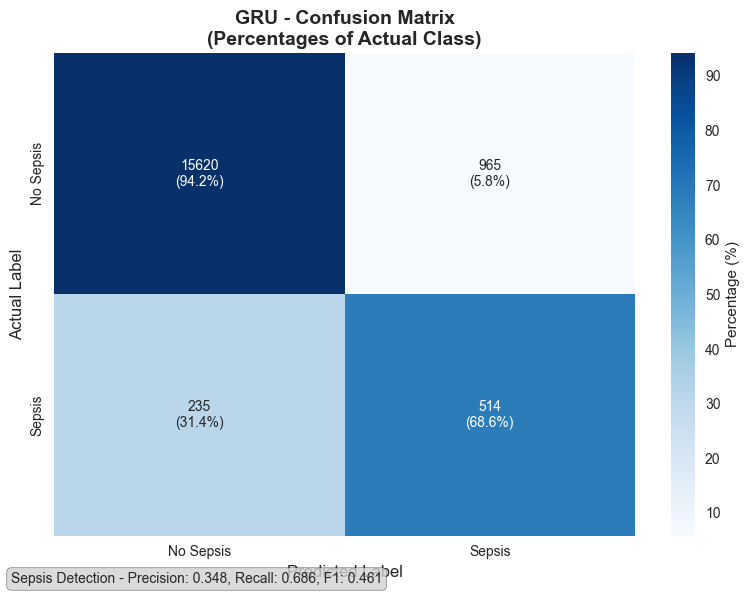

Confusion matrix heatmap saved to assets/gru_confusion_matrix.png
True Positives (Correctly identified sepsis): 514
False Negatives (Missed sepsis cases): 235
Sepsis Detection Rate: 68.6%


In [53]:
# Create confusion matrix heatmaps and save to assets folder
def create_confusion_matrix_heatmap(y_true, y_pred, model_name, save_path):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(8, 6))
    
    # Create annotations with both counts and percentages
    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percentage = cm_percentage[i, j]
            row.append(f'{count}\n({percentage:.1f}%)')
        annotations.append(row)
    
    # Create heatmap
    sns.heatmap(cm_percentage, annot=annotations, fmt='', cmap='Blues', 
                xticklabels=['No Sepsis', 'Sepsis'], 
                yticklabels=['No Sepsis', 'Sepsis'],
                cbar_kws={'label': 'Percentage (%)'})
    
    plt.title(f'{model_name} - Confusion Matrix\n(Percentages of Actual Class)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('Actual Label', fontsize=12)
    
    # Add performance metrics as text
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    
    plt.figtext(0.02, 0.02, f'Sepsis Detection - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}', 
                fontsize=10, ha='left', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm, cm_percentage

print("=== CONFUSION MATRIX ANALYSIS ===")
print("Focus: Sepsis Detection Performance (Class 1 = Sepsis)")

# Create heatmaps for tabular models
for name, result in results_tabular.items():
    print(f"\n--- {name} ---")
    save_path = f'assets/{name.lower().replace(" ", "_")}_confusion_matrix.png'
    cm, cm_pct = create_confusion_matrix_heatmap(
        y_test_tab, result['predictions'], name, save_path
    )
    print(f"Confusion matrix heatmap saved to {save_path}")
    
    # Key insights for sepsis detection
    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives (Correctly identified sepsis): {tp}")
    print(f"False Negatives (Missed sepsis cases): {fn}")
    print(f"Sepsis Detection Rate: {tp/(tp+fn):.1%}")

# Create heatmaps for sequential models  
for name, result in results_sequential.items():
    print(f"\n--- {name} ---")
    save_path = f'assets/{name.lower()}_confusion_matrix.png'
    cm, cm_pct = create_confusion_matrix_heatmap(
        y_test_seq, result['predictions'], name, save_path
    )
    print(f"Confusion matrix heatmap saved to {save_path}")
    
    # Key insights for sepsis detection
    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives (Correctly identified sepsis): {tp}")
    print(f"False Negatives (Missed sepsis cases): {fn}")
    print(f"Sepsis Detection Rate: {tp/(tp+fn):.1%}")


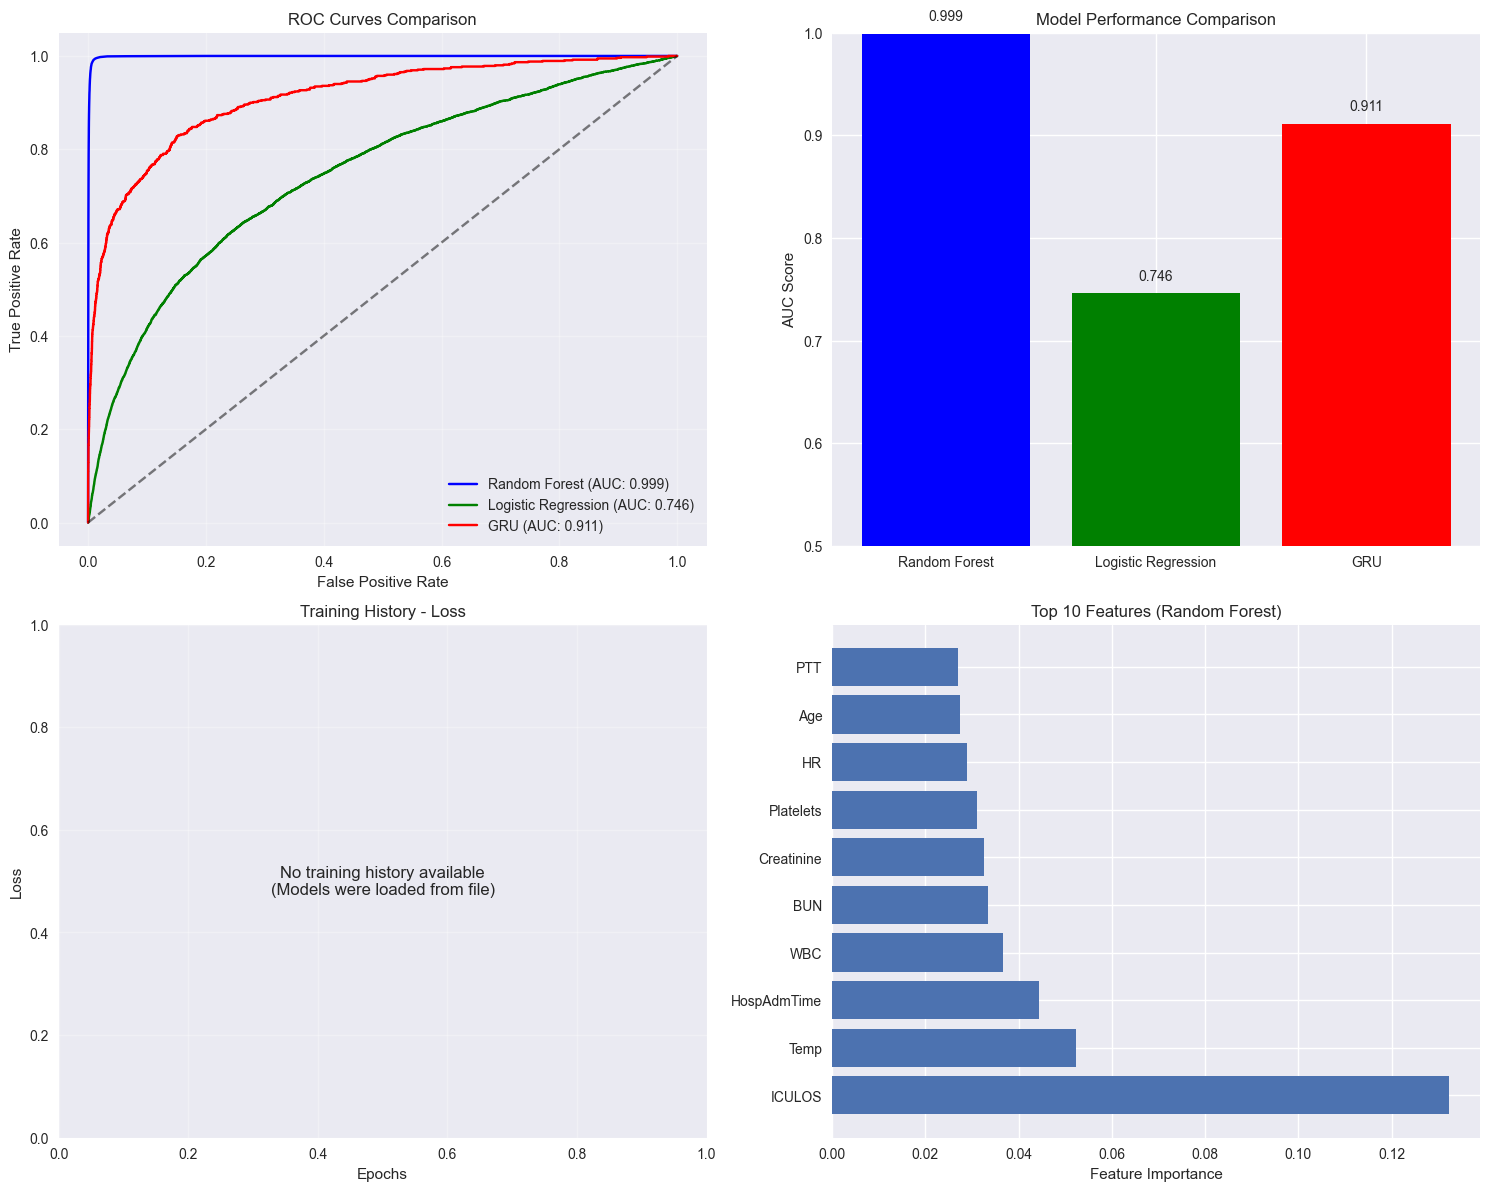

In [54]:
# Compare all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curves
ax1 = axes[0, 0]
colors = ['blue', 'green', 'red', 'orange']
model_names = []
aucs = []

# Tabular models ROC
for i, (name, result) in enumerate(results_tabular.items()):
    fpr, tpr, _ = roc_curve(y_test_tab, result['probabilities'])
    ax1.plot(fpr, tpr, color=colors[i], label=f"{name} (AUC: {result['auc']:.3f})")
    model_names.append(name)
    aucs.append(result['auc'])

# Sequential models ROC
for i, (name, result) in enumerate(results_sequential.items()):
    fpr, tpr, _ = roc_curve(y_test_seq, result['probabilities'])
    ax1.plot(fpr, tpr, color=colors[i+2], label=f"{name} (AUC: {result['auc']:.3f})")
    model_names.append(name)
    aucs.append(result['auc'])

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AUC Comparison Bar Plot
ax2 = axes[0, 1]
bars = ax2.bar(model_names, aucs, color=colors[:len(model_names)])
ax2.set_ylabel('AUC Score')
ax2.set_title('Model Performance Comparison')
ax2.set_ylim(0.5, 1.0)
for bar, auc in zip(bars, aucs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{auc:.3f}', ha='center', va='bottom')

# Training History for Sequential Models - FIXED
ax3 = axes[1, 0]
history_plotted = False
for name, result in results_sequential.items():
    if 'history' in result and isinstance(result['history'], dict):
        if 'loss' in result['history'] and len(result['history']['loss']) > 0:
            ax3.plot(result['history']['loss'], label=f'{name} Train Loss')
            ax3.plot(result['history']['val_loss'], label=f'{name} Val Loss', linestyle='--')
            history_plotted = True

if not history_plotted:
    ax3.text(0.5, 0.5, 'No training history available\n(Models were loaded from file)', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_title('Training History - Loss')
if history_plotted:
    ax3.legend()
ax3.grid(True, alpha=0.3)

# Feature Importance (Random Forest)
ax4 = axes[1, 1]
rf_model = results_tabular['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

ax4.barh(range(len(feature_importance)), feature_importance['importance'])
ax4.set_yticks(range(len(feature_importance)))
ax4.set_yticklabels(feature_importance['feature'])
ax4.set_xlabel('Feature Importance')
ax4.set_title('Top 10 Features (Random Forest)')

plt.tight_layout()
plt.show()


In [55]:
# Summary table - Focus on Sepsis Detection
summary_data = []

for name, result in results_tabular.items():
    summary_data.append({
        'Model': name,
        'Type': 'Tabular',
        'AUC': result['auc'],
        'Precision': result['precision'],
        'Recall (Sensitivity)': result['recall'],
        'F1-Score': result['f1'],
        'Data Shape': f"{X_test_tab.shape[0]} × {X_test_tab.shape[1]}"
    })

for name, result in results_sequential.items():
    summary_data.append({
        'Model': name,
        'Type': 'Sequential', 
        'AUC': result['auc'],
        'Precision': result['precision'],
        'Recall (Sensitivity)': result['recall'],
        'F1-Score': result['f1'],
        'Data Shape': f"{X_test_seq.shape[0]} × {X_test_seq.shape[1]} × {X_test_seq.shape[2]}"
    })

summary_df = pd.DataFrame(summary_data).sort_values('Recall (Sensitivity)', ascending=False)
print("\n=== SEPSIS DETECTION PERFORMANCE SUMMARY ===")
print("(Sorted by Recall/Sensitivity - Most Important for Sepsis Detection)")
print(summary_df.to_string(index=False))

# Best model for sepsis detection (highest recall)
best_sepsis_model = summary_df.iloc[0]
print(f"\n🏆 Best Sepsis Detection Model: {best_sepsis_model['Model']} ({best_sepsis_model['Type']})")
print(f"   Recall (Sensitivity): {best_sepsis_model['Recall (Sensitivity)']:.3f} ({best_sepsis_model['Recall (Sensitivity)']:.1%} of sepsis cases detected)")
print(f"   Precision: {best_sepsis_model['Precision']:.3f} (accuracy when predicting sepsis)")
print(f"   AUC: {best_sepsis_model['AUC']:.3f}")

# Best overall balanced model
best_f1_model = summary_df.sort_values('F1-Score', ascending=False).iloc[0]
print(f"\n⚖️ Best Balanced Model: {best_f1_model['Model']} ({best_f1_model['Type']})")
print(f"   F1-Score: {best_f1_model['F1-Score']:.3f} (harmonic mean of precision and recall)")

print(f"\n📊 Model files saved in 'models/' directory")
print(f"📈 Confusion matrix heatmaps saved in 'assets/' directory")



=== SEPSIS DETECTION PERFORMANCE SUMMARY ===
(Sorted by Recall/Sensitivity - Most Important for Sepsis Detection)
              Model       Type      AUC  Precision  Recall (Sensitivity)  F1-Score      Data Shape
      Random Forest    Tabular 0.999083   0.947772              0.731327  0.825599     310442 × 40
                GRU Sequential 0.911054   0.347532              0.686248  0.461400 17334 × 12 × 40
Logistic Regression    Tabular 0.746100   0.043663              0.632635  0.081687     310442 × 40

🏆 Best Sepsis Detection Model: Random Forest (Tabular)
   Recall (Sensitivity): 0.731 (73.1% of sepsis cases detected)
   Precision: 0.948 (accuracy when predicting sepsis)
   AUC: 0.999

⚖️ Best Balanced Model: Random Forest (Tabular)
   F1-Score: 0.826 (harmonic mean of precision and recall)

📊 Model files saved in 'models/' directory
📈 Confusion matrix heatmaps saved in 'assets/' directory
